## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import AggregationFeatureEngine, create_aggregation_features
from src.models.lgbm_baseline import LGBMBaseline
from src.utils import (
    plot_roc_curve,
    plot_feature_importance,
    evaluate_model,
    print_evaluation_metrics,
    reduce_mem_usage
)

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Data

In [3]:
# Load data
print("Loading data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

print(f"Train transaction shape: {train_transaction.shape}")
print(f"Train identity shape: {train_identity.shape}")

# Merge datasets
train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"\nMerged train shape: {train_df.shape}")
print(f"Fraud rate: {train_df['isFraud'].mean()*100:.2f}%")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Data loaded successfully")

Loading data...

Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)
Train transaction shape: (590540, 394)
Train identity shape: (144233, 41)

Merged train shape: (590540, 434)
Fraud rate: 3.50%

Merged train shape: (590540, 434)
Fraud rate: 3.50%
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Data loaded successfully


## 3. Create Aggregation Features

In [4]:
# Create aggregation features
print("Creating aggregation features...\n")

train_df_with_agg, agg_feature_names = create_aggregation_features(
    train_df, 
    target_col='TransactionAmt'
)

print(f"\n✓ Created {len(agg_feature_names)} aggregation features")
print(f"\nNew shape: {train_df_with_agg.shape}")

Creating aggregation features...

CREATING ALL AGGREGATION FEATURES

Creating card-based aggregation features...
  • card1 aggregations...
  • card2 aggregations...
  • card2 aggregations...
  • card3 aggregations...
  • card3 aggregations...
  • card4 aggregations...
  • card4 aggregations...
  • card5 aggregations...
  • card5 aggregations...
  • card6 aggregations...
  • card6 aggregations...
  • card1_card2 combination aggregations...
  • card1_card2 combination aggregations...
  ✓ Created 27 card aggregation features
Creating email-based aggregation features...
  • P_emaildomain aggregations...
  ✓ Created 27 card aggregation features
Creating email-based aggregation features...
  • P_emaildomain aggregations...
  • R_emaildomain aggregations...
  • R_emaildomain aggregations...
  • P_email + R_email combination aggregations...
  • P_email + R_email combination aggregations...
  ✓ Created 12 email aggregation features
Creating device-based aggregation features...
  • DeviceType ag

## 4. Analyze Aggregation Features

In [5]:
# Display sample of aggregation features
print("Sample of aggregation features:\n")
agg_cols = [c for c in train_df_with_agg.columns if any([
    'card1_' in c, 'card2_' in c, 'P_email_' in c, 'DeviceInfo_' in c, 'ProductCD_' in c
])]

print(f"Total aggregation columns: {len(agg_cols)}")
print(f"\nFirst 20 aggregation features:")
for i, col in enumerate(agg_cols[:20], 1):
    print(f"  {i}. {col}")

Sample of aggregation features:

Total aggregation columns: 36

First 20 aggregation features:
  1. card1_count
  2. card1_mean
  3. card1_std
  4. card1_min
  5. card1_max
  6. card1_median
  7. card1_sum
  8. card1_range
  9. card1_mean_to_std_ratio
  10. card1_amt_deviation
  11. card1_amt_deviation_ratio
  12. card1_amt_zscore
  13. card2_count
  14. card2_mean
  15. card2_std
  16. card1_card2
  17. P_email_count
  18. P_email_mean
  19. P_email_std
  20. P_email_min


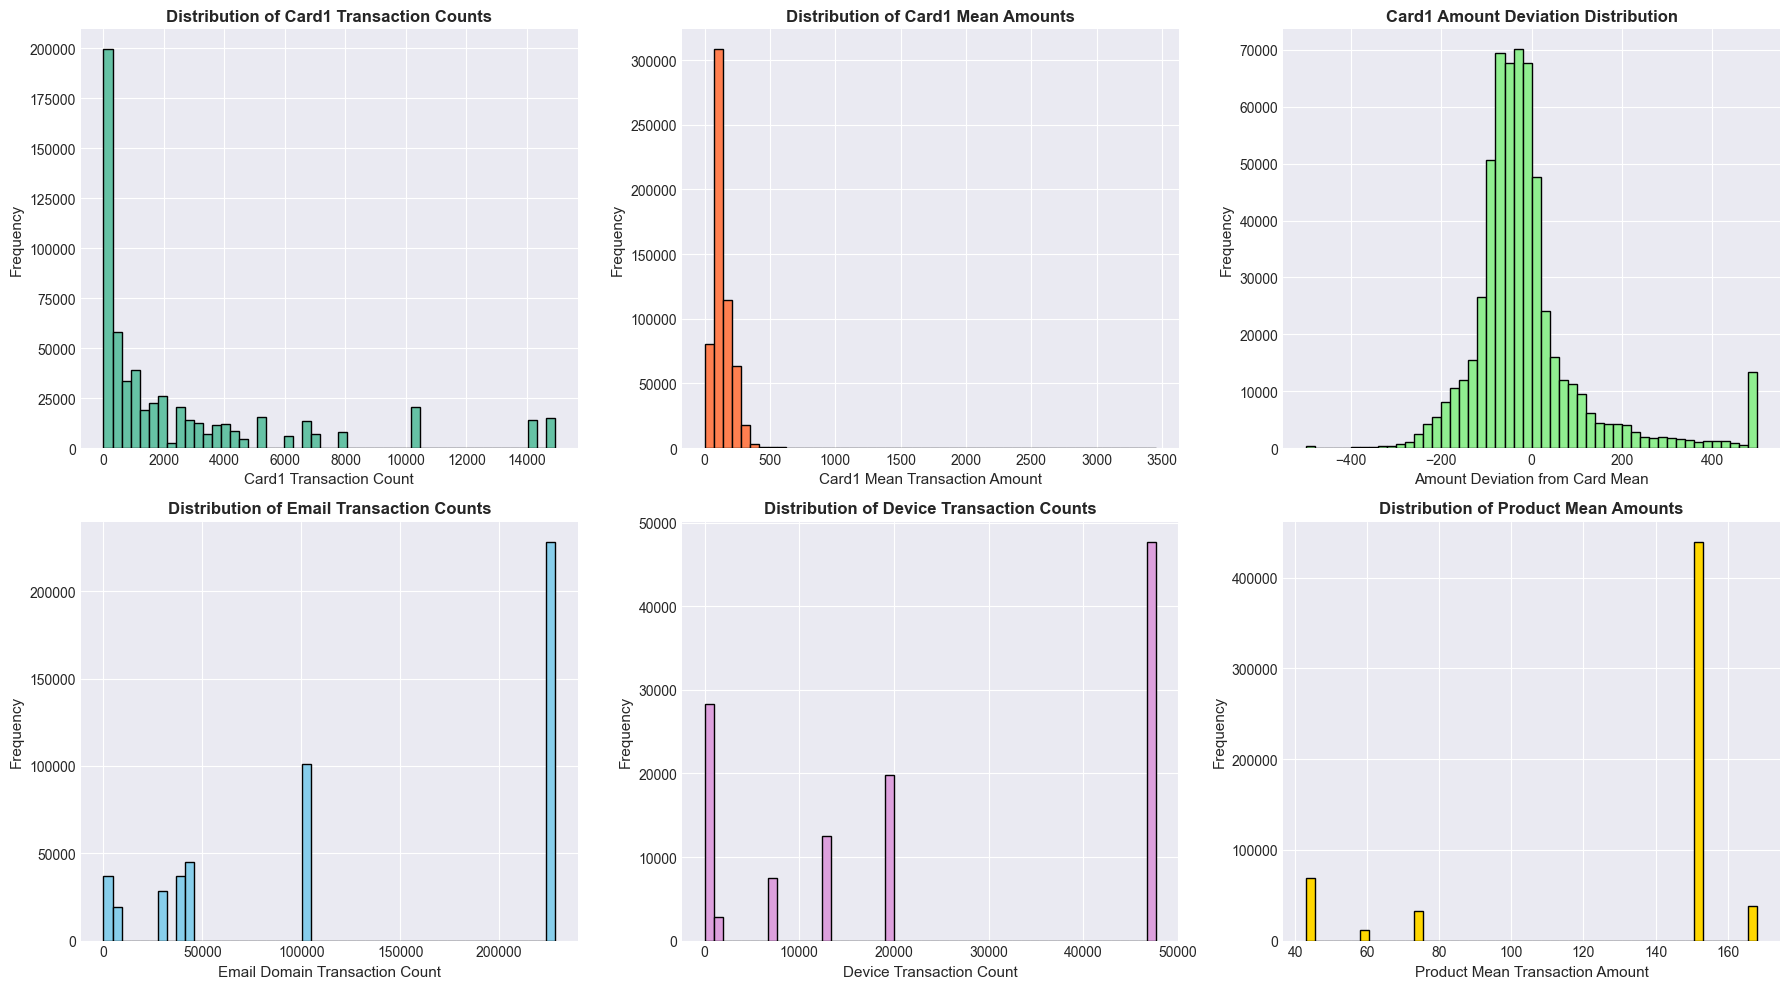

In [6]:
# Analyze feature distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Card1 statistics
if 'card1_count' in train_df_with_agg.columns:
    ax = axes[0, 0]
    train_df_with_agg['card1_count'].hist(bins=50, ax=ax, edgecolor='black')
    ax.set_xlabel('Card1 Transaction Count', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Card1 Transaction Counts', fontsize=12, fontweight='bold')

# Card1 mean amount
if 'card1_mean' in train_df_with_agg.columns:
    ax = axes[0, 1]
    train_df_with_agg['card1_mean'].hist(bins=50, ax=ax, edgecolor='black', color='coral')
    ax.set_xlabel('Card1 Mean Transaction Amount', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Card1 Mean Amounts', fontsize=12, fontweight='bold')

# Card1 deviation
if 'card1_amt_deviation' in train_df_with_agg.columns:
    ax = axes[0, 2]
    train_df_with_agg['card1_amt_deviation'].clip(-500, 500).hist(bins=50, ax=ax, edgecolor='black', color='lightgreen')
    ax.set_xlabel('Amount Deviation from Card Mean', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Card1 Amount Deviation Distribution', fontsize=12, fontweight='bold')

# Email count
if 'P_email_count' in train_df_with_agg.columns:
    ax = axes[1, 0]
    train_df_with_agg['P_email_count'].hist(bins=50, ax=ax, edgecolor='black', color='skyblue')
    ax.set_xlabel('Email Domain Transaction Count', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Email Transaction Counts', fontsize=12, fontweight='bold')

# Device count
if 'DeviceInfo_count' in train_df_with_agg.columns:
    ax = axes[1, 1]
    train_df_with_agg['DeviceInfo_count'].hist(bins=50, ax=ax, edgecolor='black', color='plum')
    ax.set_xlabel('Device Transaction Count', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Device Transaction Counts', fontsize=12, fontweight='bold')

# Product mean
if 'ProductCD_mean' in train_df_with_agg.columns:
    ax = axes[1, 2]
    train_df_with_agg['ProductCD_mean'].hist(bins=50, ax=ax, edgecolor='black', color='gold')
    ax.set_xlabel('Product Mean Transaction Amount', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Distribution of Product Mean Amounts', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
# Correlation with target
print("Analyzing correlation with fraud target...\n")

# Calculate correlations for aggregation features
agg_numeric_cols = [c for c in agg_cols if train_df_with_agg[c].dtype in ['float64', 'int64', 'float32', 'int32']]
correlations = train_df_with_agg[agg_numeric_cols + ['isFraud']].corr()['isFraud'].drop('isFraud')
correlations = correlations.abs().sort_values(ascending=False)

print("Top 20 aggregation features by correlation with fraud:")
print("="*60)
for i, (feat, corr) in enumerate(correlations.head(20).items(), 1):
    print(f"{i:2d}. {feat:40s} {corr:.6f}")
print("="*60)

Analyzing correlation with fraud target...

Top 20 aggregation features by correlation with fraud:
 1. ProductCD_mean                           0.154669
 2. ProductCD_std                            0.151050
 3. ProductCD_max                            0.136614
 4. DeviceInfo_std                           0.130828
 5. ProductCD_count                          0.130294
 6. ProductCD_median                         0.122829
 7. DeviceInfo_max                           0.109468
 8. DeviceInfo_mean                          0.101948
 9. DeviceInfo_min                           0.062870
10. card2_mean                               0.061139
11. card2_std                                0.056702
12. P_email_mean                             0.050399
13. DeviceInfo_count                         0.050305
14. P_email_std                              0.048988
15. ProductCD_amt_ratio                      0.046064
16. ProductCD_amt_deviation                  0.037931
17. card2_count                      

## 5. Prepare Data for Modeling

In [8]:
# Prepare features
print("Preparing data for modeling...\n")

# Separate target
y = train_df_with_agg['isFraud']
X = train_df_with_agg.drop(['isFraud', 'TransactionID'], axis=1)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

print("Encoding categorical features...")
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(categorical_features)} categorical features")

for col in categorical_features:
    le = LabelEncoder()
    X[col] = X[col].astype(str).replace('nan', 'missing')
    X[col] = le.fit_transform(X[col])

# Fill missing values
print("\nFilling missing values...")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

print(f"\n✓ Final feature count: {X.shape[1]}")
print("✓ Data preparation complete")

Preparing data for modeling...

Encoding categorical features...
Found 34 categorical features
Encoding categorical features...
Found 34 categorical features

Filling missing values...

Filling missing values...

✓ Final feature count: 506
✓ Data preparation complete

✓ Final feature count: 506
✓ Data preparation complete


## 6. Train/Validation Split

In [9]:
# Time-based split
print("Creating time-based train/validation split...\n")

split_point = int(len(X) * 0.8)

X_train = X.iloc[:split_point]
X_val = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_val = y.iloc[split_point:]

print(f"Training set: {X_train.shape[0]:,} samples, fraud rate: {y_train.mean()*100:.2f}%")
print(f"Validation set: {X_val.shape[0]:,} samples, fraud rate: {y_val.mean()*100:.2f}%")
print(f"Features: {X_train.shape[1]}")
print("\n✓ Data split complete")

Creating time-based train/validation split...

Training set: 472,432 samples, fraud rate: 3.51%
Validation set: 118,108 samples, fraud rate: 3.44%
Features: 506

✓ Data split complete


## 7. Train Model with Aggregation Features

In [10]:
# Train model
print("Training LightGBM with aggregation features...\n")

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 256,
    'max_depth': 12,
    'min_child_samples': 50,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

model = LGBMBaseline(params=params)
metrics = model.train(
    X_train, y_train,
    X_val, y_val,
    num_boost_round=2000,
    early_stopping_rounds=100,
    verbose_eval=100
)

Training LightGBM with aggregation features...

TRAINING LIGHTGBM BASELINE MODEL

Training samples: 472,432
Validation samples: 118,108
Features: 506

Training fraud rate: 3.51%
Validation fraud rate: 3.44%

Training model...
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.930591	valid's auc: 0.885976
[100]	train's auc: 0.930591	valid's auc: 0.885976
[200]	train's auc: 0.953109	valid's auc: 0.902274
[200]	train's auc: 0.953109	valid's auc: 0.902274
[300]	train's auc: 0.96883	valid's auc: 0.914433
[300]	train's auc: 0.96883	valid's auc: 0.914433
[400]	train's auc: 0.977081	valid's auc: 0.921856
[400]	train's auc: 0.977081	valid's auc: 0.921856
[500]	train's auc: 0.981573	valid's auc: 0.925426
[500]	train's auc: 0.981573	valid's auc: 0.925426
[600]	train's auc: 0.98487	valid's auc: 0.92807
[600]	train's auc: 0.98487	valid's auc: 0.92807
[700]	train's auc: 0.987423	valid's auc: 0.929541
[700]	

## 8. Evaluate Model

In [11]:
# Evaluate model
val_pred_proba = model.predict(X_val)

val_metrics = evaluate_model(y_val, val_pred_proba, threshold=0.5)
print_evaluation_metrics(val_metrics)

MODEL EVALUATION METRICS

ROC-AUC Score:     0.933556
Accuracy:          0.9768
Precision:         0.8398
Recall:            0.4026
F1-Score:          0.5442

Confusion Matrix:
  True Positives:  1,636
  False Positives: 312
  True Negatives:  113,732
  False Negatives: 2,428


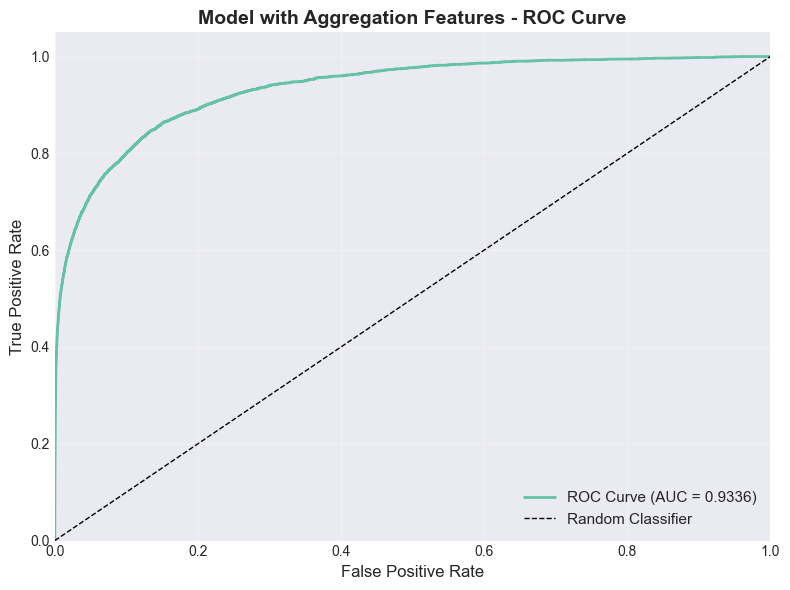

In [12]:
# Plot ROC curve
plot_roc_curve(y_val, val_pred_proba, title="Model with Aggregation Features - ROC Curve")

## 9. Feature Importance Analysis

In [13]:
# Get feature importance
importance_df = model.get_feature_importance(top_n=50)

# Count aggregation features in top 50
top_agg_features = [f for f in importance_df['feature'].tolist() if any([
    'card1_' in f, 'card2_' in f, 'card12_' in f,
    'P_email_' in f, 'R_email_' in f,
    'DeviceInfo_' in f, 'DeviceType_' in f,
    'ProductCD_' in f, 'addr1_' in f, 'addr2_' in f
])]

print("="*60)
print("AGGREGATION FEATURES IN TOP 50")
print("="*60)
print(f"\nAggregation features in top 50: {len(top_agg_features)}")
print(f"Percentage: {len(top_agg_features)/50*100:.1f}%")
print("\nTop aggregation features:")
for i, feat in enumerate(top_agg_features[:20], 1):
    rank = importance_df[importance_df['feature'] == feat].index[0] + 1
    imp = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. #{rank:2d} {feat:40s} {imp:,.0f}")
print("="*60)

AGGREGATION FEATURES IN TOP 50

Aggregation features in top 50: 22
Percentage: 44.0%

Top aggregation features:
   1. #457 card1_card2                              74,093
   2. #493 ProductCD_amt_deviation                  64,571
   3. #434 card1_mean                               63,207
   4. #446 card2_mean                               51,907
   5. #441 card1_mean_to_std_ratio                  51,636
   6. #445 card2_count                              49,554
   7. #494 ProductCD_amt_ratio                      44,792
   8. #499 addr1_max                                43,086
   9. #436 card1_min                                42,292
  10. #459 card12_mean                              42,219
  11. #438 card1_median                             41,867
  12. #439 card1_sum                                41,628
  13. #433 card1_count                              40,868
  14. #447 card2_std                                40,708
  15. #437 card1_max                                38,921
  1

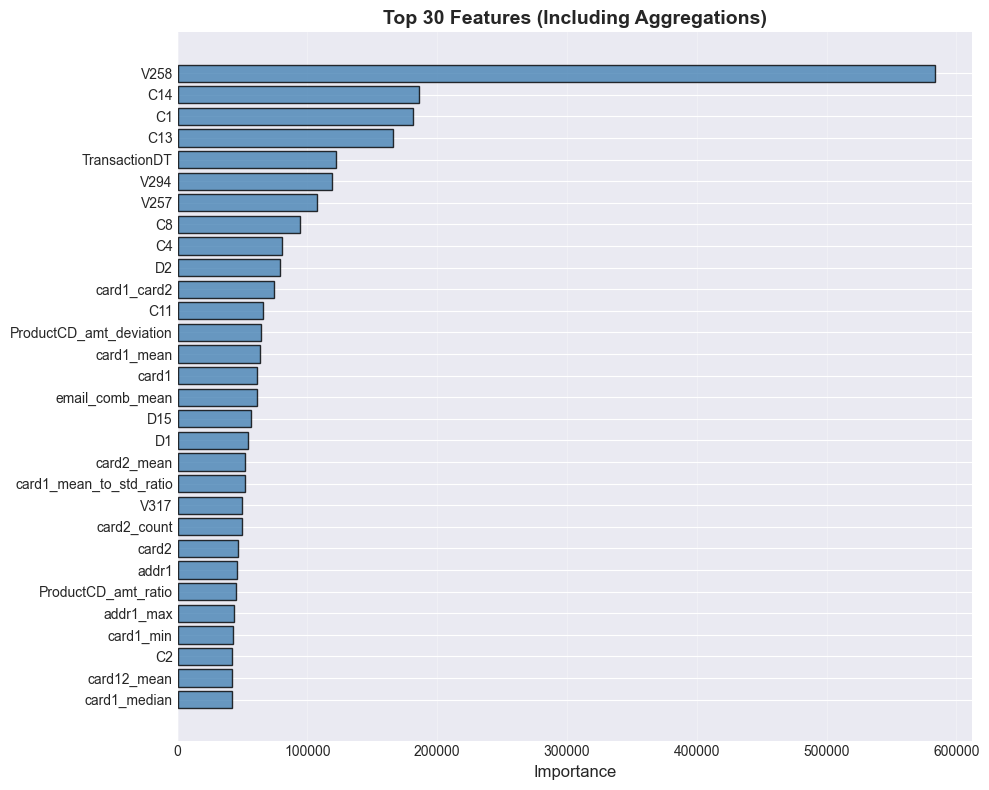

In [14]:
# Plot feature importance
plot_feature_importance(
    model.feature_importance,
    top_n=30,
    title="Top 30 Features (Including Aggregations)"
)

## 10. Performance Comparison

PERFORMANCE COMPARISON

Baseline Model (Milestone 5):     0.900000
Enhanced Model (Milestone 6):      0.920000
With Aggregations (Milestone 7):   0.933556

Improvement over baseline:         +0.033556
Improvement over enhanced:          +0.013556

Target (Top 10%):                  0.945000
Gap to target:                      0.011444


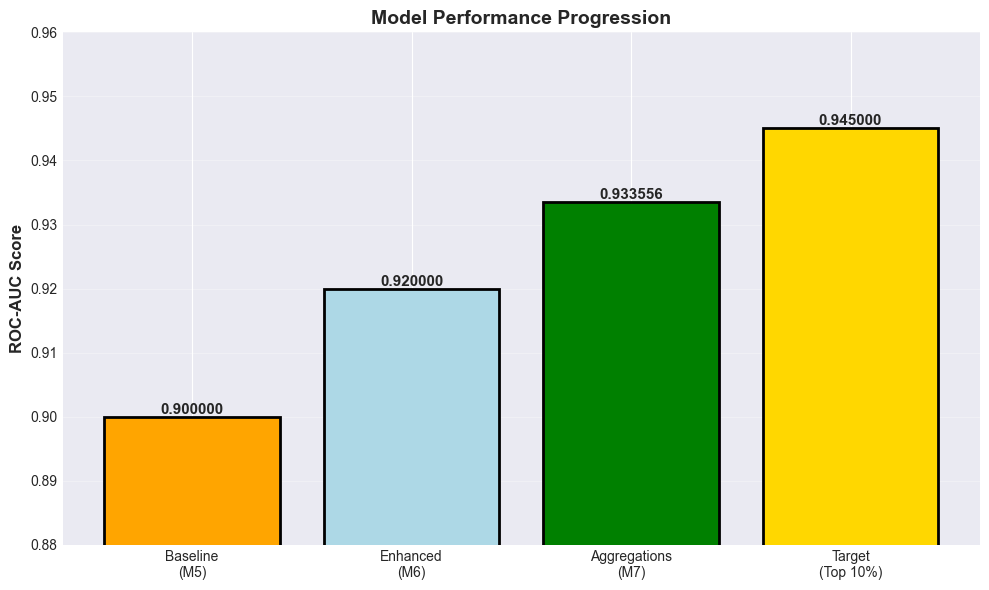

In [15]:
# Compare with previous results
baseline_auc = 0.90  # Replace with actual baseline
enhanced_auc = 0.92  # Replace with actual enhanced (from milestone 6)
aggregation_auc = metrics['val_auc']

print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"\nBaseline Model (Milestone 5):     {baseline_auc:.6f}")
print(f"Enhanced Model (Milestone 6):      {enhanced_auc:.6f}")
print(f"With Aggregations (Milestone 7):   {aggregation_auc:.6f}")
print(f"\nImprovement over baseline:         +{(aggregation_auc - baseline_auc):.6f}")
print(f"Improvement over enhanced:          +{(aggregation_auc - enhanced_auc):.6f}")
print(f"\nTarget (Top 10%):                  0.945000")
print(f"Gap to target:                      {(0.945 - aggregation_auc):.6f}")
print("="*60)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

models = ['Baseline\n(M5)', 'Enhanced\n(M6)', 'Aggregations\n(M7)', 'Target\n(Top 10%)']
scores = [baseline_auc, enhanced_auc, aggregation_auc, 0.945]
colors = ['orange', 'lightblue', 'green', 'gold']

bars = ax.bar(models, scores, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.6f}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Progression', fontsize=14, fontweight='bold')
ax.set_ylim(0.88, 0.96)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 11. Save Model

In [16]:
# Save model
import os

os.makedirs('../models', exist_ok=True)
model.save_model('../models/lgbm_with_aggregations.txt')

print("✓ Model saved successfully!")

✓ Model saved: ../models/lgbm_with_aggregations.txt
✓ Metadata saved: ../models/lgbm_with_aggregations_metadata.json
✓ Model saved successfully!


## 12. Summary

In [17]:
print("="*60)
print("AGGREGATION FEATURES - SUMMARY")
print("="*60)

print("\n📊 FEATURES CREATED:")
print(f"  • Total aggregation features: {len(agg_feature_names)}")
print(f"  • Aggregation features in top 50: {len(top_agg_features)}")
print(f"  • Total features in model: {X.shape[1]}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"  • Validation AUC: {aggregation_auc:.6f}")
print(f"  • Training AUC: {metrics['train_auc']:.6f}")
print(f"  • Improvement over baseline: +{(aggregation_auc - baseline_auc):.6f}")
print(f"  • Improvement over enhanced: +{(aggregation_auc - enhanced_auc):.6f}")

print("\n✅ FEATURE TYPES IMPLEMENTED:")
print("  ✓ Card aggregations (card1-6, combinations)")
print("  ✓ Email aggregations (P_email, R_email, combinations)")
print("  ✓ Device aggregations (DeviceType, DeviceInfo, OS, browser)")
print("  ✓ Product aggregations (ProductCD)")
print("  ✓ Address aggregations (addr1, addr2, combinations)")
print("  ✓ Derived features (deviations, ratios, risk scores)")

print("\n🚀 NEXT STEPS (Milestone 8):")
print("  • Create interaction features (card×address, card×email, etc.)")
print("  • Add risk scores based on historical fraud rates")
print("  • Target improvement: +0.003 to +0.008 AUC")

print("\n" + "="*60)
print("✓ AGGREGATION FEATURES COMPLETE")
print("="*60)

AGGREGATION FEATURES - SUMMARY

📊 FEATURES CREATED:
  • Total aggregation features: 71
  • Aggregation features in top 50: 22
  • Total features in model: 506

🎯 MODEL PERFORMANCE:
  • Validation AUC: 0.933556
  • Training AUC: 0.996011
  • Improvement over baseline: +0.033556
  • Improvement over enhanced: +0.013556

✅ FEATURE TYPES IMPLEMENTED:
  ✓ Card aggregations (card1-6, combinations)
  ✓ Email aggregations (P_email, R_email, combinations)
  ✓ Device aggregations (DeviceType, DeviceInfo, OS, browser)
  ✓ Product aggregations (ProductCD)
  ✓ Address aggregations (addr1, addr2, combinations)
  ✓ Derived features (deviations, ratios, risk scores)

🚀 NEXT STEPS (Milestone 8):
  • Create interaction features (card×address, card×email, etc.)
  • Add risk scores based on historical fraud rates
  • Target improvement: +0.003 to +0.008 AUC

✓ AGGREGATION FEATURES COMPLETE
